In [ ]:
!pip install segmentation-models-pytorch
!pip install -U opencv-python
!pip install --force-reinstall albumentations==1.0.3
!pip install -U albumentations[imgaug]
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached albumentations-1.0.3-py3-none-any.whl (98 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached scikit_image-0.19.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (13.5 MB)
  Using cached opencv_python_headless-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (48.3 MB)
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Using cached imageio-2.19.3-py3-none-any.whl (3.4 MB)
  Using cached Pillow-9.2.0-cp37-cp37m-manylin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import gc
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
device


device(type='cuda', index=0)

In [ ]:
from torchvision import transforms

toTensor = transforms.ToTensor()


In [ ]:
DATA_DIR = './/data//CamVid//'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

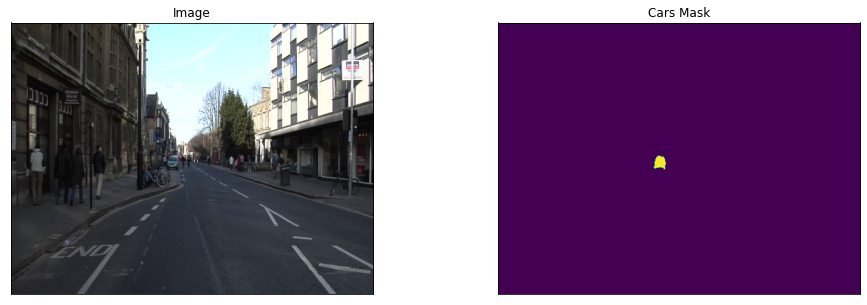

In [ ]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [ ]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

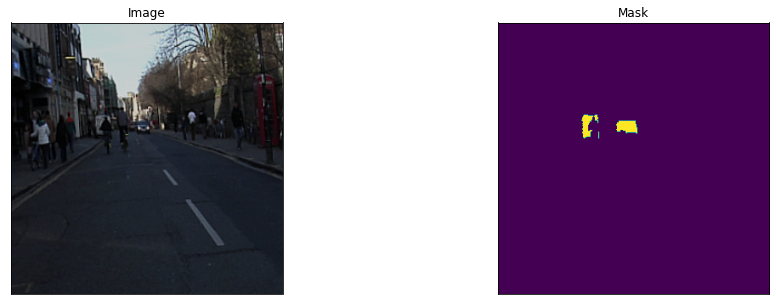

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

# same image with different random transforms
#a,b =augmented_dataset.__getitem__(2)
#visualize(image=a, mask=b.squeeze(-1))

a,b =augmented_dataset.__getitem__(2)
visualize(image=a, mask=b.squeeze(-1))

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

CLASSES= ['car']
num_classes = len(CLASSES)
UnetVGG16 = smp.Unet('vgg16',classes=len(CLASSES),encoder_weights='imagenet')

In [ ]:
preprocessing_fn = smp.encoders.get_preprocessing_fn('vgg16', 'imagenet')

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=True)

def get_all_transformed(dataset):
    assert isinstance(dataset,torch.utils.data.dataset.Subset) or issubclass(type(dataset), Dataset)

    loader = DataLoader(dataset, batch_size=len(dataset))
    for X,y in loader:
        X_T = X
        y_T = y

    return X_T,y_T    

# X_val,y_val = get_all_transformed(valid_dataset)
# X_val,y_val = X_val[:50],y_val[:50]
# X_val.shape

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

In [ ]:
from torchmetrics import JaccardIndex
from tqdm import tqdm
import time
import torch.nn as nn


def get_mIoU(y_pred, y_true,num_classes,device):
    
    if y_true.dtype != 'torch.LongTensor':
        y_true = y_true.long()
    if y_pred.dtype != 'torch.LongTensor':
        y_pred = y_pred.long()
        
    y_pred, y_true = y_pred.to(device),y_true.to(device)
        
    mIoU = JaccardIndex(num_classes=num_classes).to(device)
    mIoU = mIoU(y_pred, y_true).item()
    return mIoU

def get_IoU(y_pred,y_true,class_idx):
    pred_inds = y_pred==class_idx
    target_inds = y_true ==class_idx

    if target_inds.sum().item() == 0:
        return np.nan
    else:
        intersection = pred_inds[target_inds].sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection
        iou = intersection/union
        return iou


def eval_model(model,dataloader,criterion,num_classes,device):
  model.eval() # set model to evaluation mode

  with torch.no_grad():
    with tqdm(dataloader, unit="batch") as batch:
      loss_list = []
      mIoU_list = []
      for X,y in batch:

            batch.set_description("Evaluating")
            
            X, y = X.to(device),y.to(device)
            # compute output
            y_hat = model(X)
            # remove the channel dimension of y
            # before: dim of y: [batch_size, 1, height, width]
            # after : dim of y: [batch_size, height, width]
            y = y.type(torch.LongTensor)
            y = torch.squeeze(y, 1)
            y = y.to(device)
            loss = criterion(y_hat, y)
            y_pred = torch.argmax(y_hat, 1)
            meanIoU = get_mIoU(y_pred,y,num_classes,device)

            loss_list.append(loss.item())
            mIoU_list.append(meanIoU)
            batch.set_postfix(cross_entropy_loss = round(loss.item(),3),meanIoU = round(meanIoU,3))
            
  return np.mean(loss_list),np.mean(mIoU_list)



In [ ]:

def train(model,model_name,trainloader,num_classes,criterion,optimizer,epochs,device,validloader=None):
    if device.type != 'cpu':
        torch.cuda.synchronize()
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
    use_val = validloader != None
    train_batch_loss = []
    train_epoch_loss = []
    train_batch_iou = []
    train_epoch_iou = []
    val_epoch_loss = []
    val_epoch_iou = []
    val_iou_max = 0.0
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss =[]
        running_iou = []
        with tqdm(trainloader, unit="batch") as batch:
            for X,y in batch:                          
                batch.set_description(f"Epoch {epoch+1}")
                model.train() # set model to training mode
                X,y = X.to(device),y.to(device)         
                # x: image to predict on
                # y: predicated segmentation mask from model
                #  zero the parameter gradients
                #  PyTorch accumulates the gradients on subsequent backward passes: loss.backward()
                optimizer.zero_grad()            
                # forward + backward + optimize
                if device.type != 'cpu':
                    torch.cuda.synchronize()
                    start.record()
                    y_hat = model(X)
                    end.record()
                    torch.cuda.synchronize()
                    forward_time = round(start.elapsed_time(end)*0.001,3)  # seconds
                else:
                    start = time.time()
                    y_hat = model(X)
                    end = time.time()
                    forward_time = round(end-start,3)# seconds
                # remove the channel dimension of y
                # dim of y: [batch_size, 1, height, width] -> dim of y: [batch_size, height, width]
                y = y.type(torch.LongTensor)
                y = torch.squeeze(y, 1)
                y = y.to(device)
                loss = criterion(y_hat, y)
                if device.type != 'cpu':
                    start.record()
                    loss.backward() # dloss/da for every parameter a which has requires_grad=True. update a.grad
                    end.record()
                    torch.cuda.synchronize()
                    backward_time = round(start.elapsed_time(end)*0.001,3)  # seconds
                else:
                    start = time.time()
                    loss.backward()
                    end = time.time()
                    backward_time = round(end-start,3)# seconds
                optimizer.step() # updates the value of parmaeter a using the gradient a.grad. a += -lr * a.grad                
                y_pred_train = torch.argmax(y_hat, 1)
                meanIoU_train = get_mIoU(y_pred_train,y,num_classes,device)
                running_loss.append(loss.item())
                train_batch_loss.append(loss.item())
                running_iou.append(meanIoU_train)
                train_batch_iou.append(meanIoU_train)                
                batch.set_postfix_str(
                    f"train_loss={round(loss.item(),4)}, train_mIoU = {round(meanIoU_train,3)}, forward {forward_time}s, backward {backward_time}s.")#,epoch_running_loss = running_loss)#, accuracy=100. * accuracy)
            
            if epoch %20 ==0: # save mode every 20 epoch
              torch.save(model.state_dict(), f'./model_epoch{epoch}.pth')
            
            epoch_loss = np.mean(running_loss)
            train_epoch_loss.append(epoch_loss)
            epoch_iou = np.mean(running_iou)
            train_epoch_iou.append(epoch_iou)
            
            if use_val:
                val_loss,val_iou = eval_model(model,validloader,criterion,num_classes,device)
                val_epoch_loss.append(val_loss)
                val_epoch_iou.append(val_iou)
                if val_iou > val_iou_max:
                  torch.save(model.state_dict(), f'./{model_name}_currbest.pth')
                tqdm.write("Epoch train loss = %.3f, train mIoU = %.3f, validation loss = %.3f, mIoU = %.3f "%(epoch_loss,epoch_iou,val_loss,val_iou))
            else:
                tqdm.write("Epoch train loss = %.3f, train mIoU = %.3f"%(epoch_loss,epoch_iou))

    if use_val:
        return model,train_epoch_loss,train_epoch_iou,val_epoch_loss,val_epoch_iou
    else:
        return model,train_epoch_loss,train_epoch_iou 

In [ ]:

gc.collect()
torch.cuda.empty_cache()

UnetVGG16 = smp.Unet('vgg16',classes=2,encoder_weights='imagenet')
model = UnetVGG16

# PATH = './UnetFreezeEncoder_trained30ep.pth'
# model.load_state_dict(torch.load(PATH))

model.to(device)

for parma in model._modules['encoder'].parameters():
    parma.requires_grad = False

# for parma in model._modules['decoder'].parameters():
#     parma.requires_grad = False

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)   
print("after freezing encoder and decoder, number of trainable parameters: %d"%pytorch_total_params)

lr = 0.005
momentum = 0.9
epochs = 50
batch_size = 10
optimizer = torch.optim.SGD(params=model.parameters(),lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

num_classes=2

start_time = time.time()
model,train_epoch_loss,train_epoch_iou,val_epoch_loss, val_epoch_iou = train(model,
                  "UNet5e-3lr",
                  train_loader,num_classes,criterion,
                  optimizer,epochs,device,validloader = valid_loader)#,(X_val,y_val))
end_time = time.time()
print("Finished training, total time: %.3fmin"%((end_time-start_time)/60))


# save trained model
path = f"UnetFreezeEncoder{epochs}ep5e-3lr.pth"
torch.save(model.state_dict(), path)


after freezing encoder and decoder, number of trainable parameters: 9033698


  0%|          | 0/101 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.29batch/s, cross_entropy_loss=0.081, meanIoU=0.508]


Epoch train loss = 0.282, train mIoU = 0.468, validation loss = 0.104, mIoU = 0.505 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.46batch/s, cross_entropy_loss=0.063, meanIoU=0.519]


Epoch train loss = 0.203, train mIoU = 0.479, validation loss = 0.082, mIoU = 0.508 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.57batch/s, cross_entropy_loss=0.07, meanIoU=0.557]


Epoch train loss = 0.183, train mIoU = 0.488, validation loss = 0.082, mIoU = 0.536 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.30batch/s, cross_entropy_loss=0.069, meanIoU=0.603]


Epoch train loss = 0.176, train mIoU = 0.504, validation loss = 0.076, mIoU = 0.568 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.62batch/s, cross_entropy_loss=0.074, meanIoU=0.62]


Epoch train loss = 0.161, train mIoU = 0.544, validation loss = 0.076, mIoU = 0.610 


Evaluating: 100%|██████████| 101/101 [00:06<00:00, 15.55batch/s, cross_entropy_loss=0.086, meanIoU=0.585]


Epoch train loss = 0.147, train mIoU = 0.613, validation loss = 0.079, mIoU = 0.611 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.46batch/s, cross_entropy_loss=0.1, meanIoU=0.566]


Epoch train loss = 0.127, train mIoU = 0.674, validation loss = 0.091, mIoU = 0.598 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.38batch/s, cross_entropy_loss=0.073, meanIoU=0.605]


Epoch train loss = 0.114, train mIoU = 0.714, validation loss = 0.065, mIoU = 0.627 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.59batch/s, cross_entropy_loss=0.043, meanIoU=0.662]


Epoch train loss = 0.102, train mIoU = 0.742, validation loss = 0.039, mIoU = 0.674 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.46batch/s, cross_entropy_loss=0.045, meanIoU=0.664]


Epoch train loss = 0.085, train mIoU = 0.765, validation loss = 0.039, mIoU = 0.685 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.33batch/s, cross_entropy_loss=0.036, meanIoU=0.687]


Epoch train loss = 0.080, train mIoU = 0.791, validation loss = 0.031, mIoU = 0.706 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.44batch/s, cross_entropy_loss=0.033, meanIoU=0.7]


Epoch train loss = 0.086, train mIoU = 0.782, validation loss = 0.028, mIoU = 0.727 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.52batch/s, cross_entropy_loss=0.029, meanIoU=0.713]


Epoch train loss = 0.075, train mIoU = 0.796, validation loss = 0.025, mIoU = 0.735 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.40batch/s, cross_entropy_loss=0.029, meanIoU=0.715]


Epoch train loss = 0.075, train mIoU = 0.791, validation loss = 0.025, mIoU = 0.744 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.39batch/s, cross_entropy_loss=0.025, meanIoU=0.741]


Epoch train loss = 0.073, train mIoU = 0.803, validation loss = 0.022, mIoU = 0.756 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.28batch/s, cross_entropy_loss=0.022, meanIoU=0.765]


Epoch train loss = 0.072, train mIoU = 0.808, validation loss = 0.021, mIoU = 0.761 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.54batch/s, cross_entropy_loss=0.021, meanIoU=0.763]


Epoch train loss = 0.071, train mIoU = 0.811, validation loss = 0.019, mIoU = 0.769 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.49batch/s, cross_entropy_loss=0.016, meanIoU=0.803]


Epoch train loss = 0.069, train mIoU = 0.809, validation loss = 0.016, mIoU = 0.764 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.34batch/s, cross_entropy_loss=0.022, meanIoU=0.746]


Epoch train loss = 0.069, train mIoU = 0.811, validation loss = 0.019, mIoU = 0.772 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.26batch/s, cross_entropy_loss=0.021, meanIoU=0.757]


Epoch train loss = 0.068, train mIoU = 0.819, validation loss = 0.020, mIoU = 0.782 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.32batch/s, cross_entropy_loss=0.02, meanIoU=0.756]


Epoch train loss = 0.066, train mIoU = 0.818, validation loss = 0.018, mIoU = 0.787 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.50batch/s, cross_entropy_loss=0.016, meanIoU=0.815]


Epoch train loss = 0.059, train mIoU = 0.827, validation loss = 0.016, mIoU = 0.794 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.44batch/s, cross_entropy_loss=0.015, meanIoU=0.82]


Epoch train loss = 0.059, train mIoU = 0.831, validation loss = 0.016, mIoU = 0.792 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.26batch/s, cross_entropy_loss=0.013, meanIoU=0.835]


Epoch train loss = 0.062, train mIoU = 0.834, validation loss = 0.014, mIoU = 0.795 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.46batch/s, cross_entropy_loss=0.013, meanIoU=0.829]


Epoch train loss = 0.062, train mIoU = 0.826, validation loss = 0.013, mIoU = 0.796 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.49batch/s, cross_entropy_loss=0.017, meanIoU=0.78]


Epoch train loss = 0.054, train mIoU = 0.843, validation loss = 0.016, mIoU = 0.799 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.30batch/s, cross_entropy_loss=0.014, meanIoU=0.834]


Epoch train loss = 0.059, train mIoU = 0.830, validation loss = 0.014, mIoU = 0.808 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.26batch/s, cross_entropy_loss=0.013, meanIoU=0.843]


Epoch train loss = 0.057, train mIoU = 0.838, validation loss = 0.013, mIoU = 0.809 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.43batch/s, cross_entropy_loss=0.014, meanIoU=0.823]


Epoch train loss = 0.058, train mIoU = 0.835, validation loss = 0.014, mIoU = 0.815 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.34batch/s, cross_entropy_loss=0.016, meanIoU=0.796]


Epoch train loss = 0.054, train mIoU = 0.843, validation loss = 0.015, mIoU = 0.810 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.37batch/s, cross_entropy_loss=0.013, meanIoU=0.841]


Epoch train loss = 0.059, train mIoU = 0.839, validation loss = 0.013, mIoU = 0.815 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.23batch/s, cross_entropy_loss=0.012, meanIoU=0.847]


Epoch train loss = 0.056, train mIoU = 0.839, validation loss = 0.013, mIoU = 0.815 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.26batch/s, cross_entropy_loss=0.017, meanIoU=0.778]


Epoch train loss = 0.055, train mIoU = 0.843, validation loss = 0.015, mIoU = 0.808 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.16batch/s, cross_entropy_loss=0.014, meanIoU=0.819]


Epoch train loss = 0.052, train mIoU = 0.842, validation loss = 0.013, mIoU = 0.815 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.36batch/s, cross_entropy_loss=0.012, meanIoU=0.85]


Epoch train loss = 0.050, train mIoU = 0.843, validation loss = 0.012, mIoU = 0.822 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.26batch/s, cross_entropy_loss=0.013, meanIoU=0.833]


Epoch train loss = 0.051, train mIoU = 0.845, validation loss = 0.013, mIoU = 0.814 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.25batch/s, cross_entropy_loss=0.014, meanIoU=0.817]


Epoch train loss = 0.053, train mIoU = 0.847, validation loss = 0.014, mIoU = 0.820 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.22batch/s, cross_entropy_loss=0.012, meanIoU=0.844]


Epoch train loss = 0.048, train mIoU = 0.852, validation loss = 0.013, mIoU = 0.818 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.26batch/s, cross_entropy_loss=0.01, meanIoU=0.865]


Epoch train loss = 0.053, train mIoU = 0.844, validation loss = 0.011, mIoU = 0.817 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.25batch/s, cross_entropy_loss=0.008, meanIoU=0.9]


Epoch train loss = 0.049, train mIoU = 0.853, validation loss = 0.011, mIoU = 0.796 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.22batch/s, cross_entropy_loss=0.011, meanIoU=0.858]


Epoch train loss = 0.048, train mIoU = 0.857, validation loss = 0.012, mIoU = 0.822 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.30batch/s, cross_entropy_loss=0.011, meanIoU=0.858]


Epoch train loss = 0.045, train mIoU = 0.858, validation loss = 0.012, mIoU = 0.831 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.55batch/s, cross_entropy_loss=0.01, meanIoU=0.869]


Epoch train loss = 0.047, train mIoU = 0.861, validation loss = 0.011, mIoU = 0.824 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.36batch/s, cross_entropy_loss=0.012, meanIoU=0.859]


Epoch train loss = 0.055, train mIoU = 0.842, validation loss = 0.013, mIoU = 0.828 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.25batch/s, cross_entropy_loss=0.012, meanIoU=0.839]


Epoch train loss = 0.055, train mIoU = 0.846, validation loss = 0.012, mIoU = 0.828 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.17batch/s, cross_entropy_loss=0.009, meanIoU=0.884]


Epoch train loss = 0.048, train mIoU = 0.853, validation loss = 0.011, mIoU = 0.824 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.41batch/s, cross_entropy_loss=0.009, meanIoU=0.888]


Epoch train loss = 0.048, train mIoU = 0.850, validation loss = 0.011, mIoU = 0.831 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.12batch/s, cross_entropy_loss=0.012, meanIoU=0.841]


Epoch train loss = 0.046, train mIoU = 0.861, validation loss = 0.012, mIoU = 0.831 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.55batch/s, cross_entropy_loss=0.011, meanIoU=0.857]


Epoch train loss = 0.049, train mIoU = 0.860, validation loss = 0.011, mIoU = 0.829 


Evaluating: 100%|██████████| 101/101 [00:05<00:00, 19.56batch/s, cross_entropy_loss=0.009, meanIoU=0.883]


Epoch train loss = 0.049, train mIoU = 0.850, validation loss = 0.011, mIoU = 0.830 
Finished training, total time: 19.667min


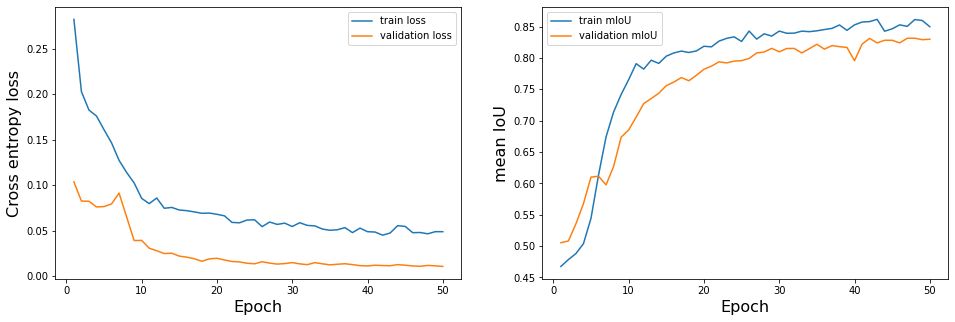

In [ ]:


fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(np.arange(1,len(train_epoch_loss)+1),train_epoch_loss,label="train loss")
ax[0].plot(np.arange(1,len(train_epoch_loss)+1),val_epoch_loss,label="validation loss")
ax[0].set_xlabel("Epoch",fontsize=16)
ax[0].set_ylabel("Cross entropy loss", fontsize=16)
ax[0].legend()
ax[1].plot(np.arange(1,len(train_epoch_loss)+1),train_epoch_iou,label="train mIoU")
ax[1].plot(np.arange(1,len(train_epoch_loss)+1),val_epoch_iou,label="validation mIoU")
ax[1].set_xlabel("Epoch",fontsize=16)
ax[1].set_ylabel("mean IoU", fontsize=16)
ax[1].legend()


In [ ]:
train_progress = dict({"train_loss": train_epoch_loss,
                      "train_mIoU": train_epoch_iou,
                      "val_loss": val_epoch_loss, 
                      "val_iou": val_epoch_iou})

with open("Unet_50epslr5e-3_progress", "w") as outfile:
    json.dump(train_progress, outfile, indent=4)

Test performance

In [ ]:
# load best saved checkpoint

best_model = UnetVGG16
PATH = './UnetFreezeEncoder50ep5e-3lr.pth'
best_model.load_state_dict(torch.load(PATH))
type(best_model)

segmentation_models_pytorch.unet.model.Unet

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset,batch_size=20)

# evaluate model on test set

num_classes = 2
criterion = nn.CrossEntropyLoss()
best_model.to(device)
test_loss, test_mIoU = eval_model(best_model,test_dataloader,criterion,num_classes,device)

print("\n Test Cross entropy loss: %.4f, mIoU %.4f"%(test_loss,test_mIoU))


Evaluating: 100%|██████████| 12/12 [00:12<00:00,  1.00s/batch, cross_entropy_loss=0.035, meanIoU=0.859]


 Test Cross entropy loss: 0.0391, mIoU 0.8517


Visualize result

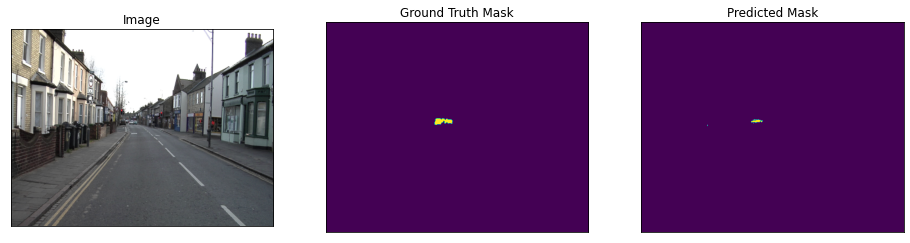

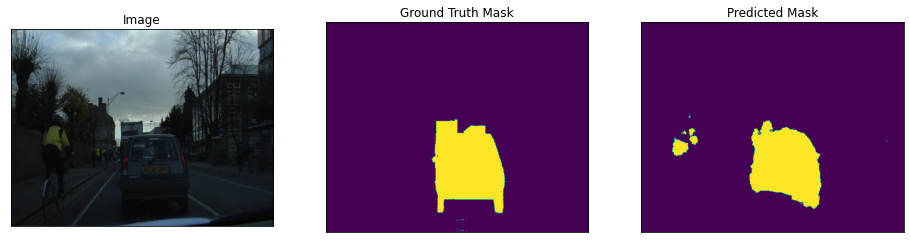

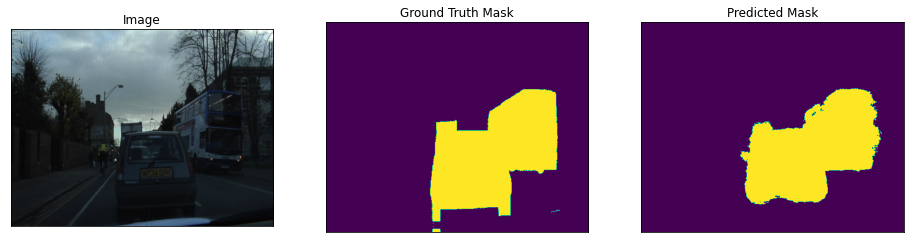

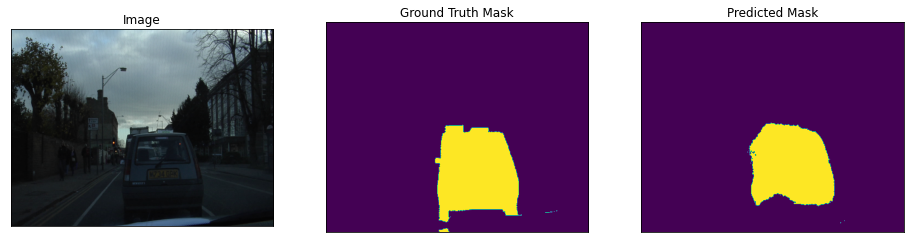

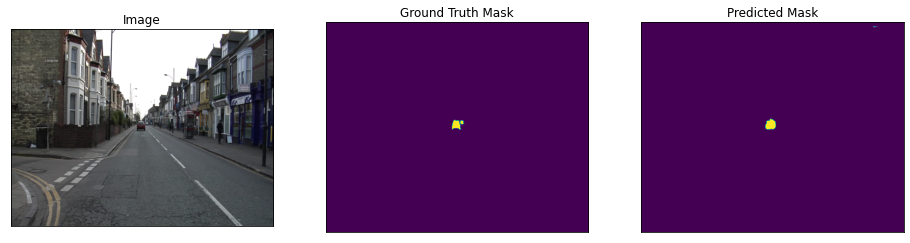

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)


for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_maskprob =best_model.predict(x_tensor)
    pr_mask = torch.argmax(pr_maskprob,dim=1).cpu().squeeze(dim=0).numpy()
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

